In [1]:
import helpers.input_processor as input_processor

# Import the data into dataset

In [2]:
data_dir = 'data/raw_training/training_data/'
data_frame = input_processor.ingest_data(data_dir)

Reading from .txt files in data/raw_training/training_data/: 100%|██████████| 942/942 [00:00<00:00, 11458.72it/s]


# create code for segmenting data

In [3]:
import os
import shutil
segmented_data = 'data/segmented/training/'
segmented_data_test = 'data/segmented/testing/'

pos_dir = segmented_data + 'pos/'
neg_dir = segmented_data + 'neg/'

pos_dir_test = segmented_data_test + 'pos/'
neg_dir_test = segmented_data_test + 'neg/'

# create the above folder path
if not os.path.exists(segmented_data):
    os.makedirs(segmented_data)
    os.makedirs(pos_dir)
    os.makedirs(neg_dir)

if not os.path.exists(segmented_data_test):
    os.makedirs(segmented_data_test)
    os.makedirs(pos_dir_test)
    os.makedirs(neg_dir_test)

# remove the files in the folder
for file in os.listdir(pos_dir):
    os.remove(pos_dir + file)
for file in os.listdir(neg_dir):
    os.remove(neg_dir + file)

# remove the files in the folder
for file in os.listdir(pos_dir_test):
    os.remove(pos_dir_test + file)
for file in os.listdir(neg_dir_test):
    os.remove(neg_dir_test + file)

def randomsplit(train_percentage):
    # pick a random number between 0 and 1 with the given percentage
    import random
    random_number = random.random()
    if random_number < train_percentage:
        return True
    else:
        return False
    


for i in range(len(data_frame)):
    for files in data_frame[i]["audio_file"].to_list():
        for file in files:
            # check if the audio_file has a murmur location
            contains_murmur = False
            for murmur_locations in data_frame[i]["murmur_locations"].to_list():
                for location in murmur_locations:
                    # check if the murmur location is in the string of audio_file
                    if location in file:
                        # if so, add the spectrogram to the positive folder
                        
                        if (randomsplit(0.8)):
                            shutil.copyfile(data_dir + file, pos_dir + file)
                        else:
                            shutil.copyfile(data_dir + file, pos_dir_test + file)
             
                        contains_murmur = True
            if not contains_murmur:
                # if the file is not a murmur, add the spectrogram to the negative folder
               
                if (randomsplit(0.8)):
                    shutil.copyfile(data_dir + file, neg_dir + file)
                else:
                    shutil.copyfile(data_dir + file, neg_dir_test + file)


## Import deep learning libraries

In [4]:
import tensorflow as tf 
import tensorflow_io as tfio

2022-07-13 09:59:20.386037: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Build audio file loading function

In [5]:
def load_audio_file(filename):
    contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(contents, desired_channels=1)
    # remove trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, tf.int64)
    # reduce sample rate to 16kHz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Plot Wave

In [6]:
# pick a file from the positive folder
pos_file = pos_dir + os.listdir(pos_dir)[0]
# pick a file from the negative folder
neg_file = neg_dir + os.listdir(neg_dir)[0]

wave = load_audio_file(pos_file)
nwave = load_audio_file(neg_file)

2022-07-13 09:59:22.428875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 09:59:23.006916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-07-13 09:59:23.526165: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


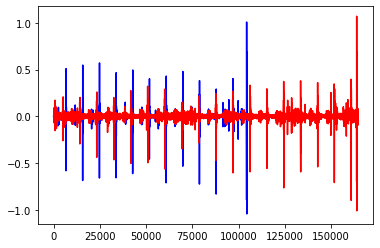

In [7]:
import matplotlib.pyplot as plt

plt.plot(wave, color='blue')
plt.plot(nwave, color='r')

# Create Tensorflow Dataset

In [8]:
pos_dataset = tf.data.Dataset.list_files(pos_dir + '*.wav')
neg_dataset = tf.data.Dataset.list_files(neg_dir + '*.wav')


In [9]:

percentage = (neg_dataset.__len__().numpy() / (pos_dataset.__len__().numpy() + neg_dataset.__len__().numpy())) * 100 # percentage of negative files 
print(percentage, '% of the files are negative')
print(pos_dataset.__len__().numpy(), 'positive files')
print(neg_dataset.__len__().numpy(), 'negative files')

83.82120253164557 % of the files are negative
409 positive files
2119 negative files


In [10]:
# duplicate the dataset to make it balanced 499 positive files to 2664 positive files
pos_dataset_repeated = pos_dataset.repeat(5)

print(pos_dataset_repeated.__len__().numpy(), 'positive files')
percentage = (neg_dataset.__len__().numpy() / (pos_dataset_repeated.__len__().numpy() + neg_dataset.__len__().numpy())) * 100 # percentage of negative files
print(percentage, '% of the files are negative')

2045 positive files
50.888568683957736 % of the files are negative


### Add labels and combine dataset

In [11]:
positives = tf.data.Dataset.zip((pos_dataset_repeated, tf.data.Dataset.from_tensor_slices(tf.ones(shape=(len(pos_dataset_repeated))))))
negatives = tf.data.Dataset.zip((neg_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(shape=(len(neg_dataset))))))
data = positives.concatenate(negatives)

In [12]:
length = data.__len__().numpy()

# shuffle the data
data = data.shuffle(buffer_size=(length))
# split the data into training and testing sets
train_size = int(length * 0.8)
test_size = int(length * 0.2)


train_dataset = data.take(train_size)
test_dataset = data.skip(train_size)

## Find length data of audio clips

In [13]:
#import tqdm
#
#loading_bar = tqdm.tqdm(total=len(data))
#loading_bar.set_description('Loading data')
#
#lengths = []
#for file in os.listdir(pos_dir):
#    tensor_wave = load_audio_file(pos_dir + file)
#    lengths.append(len(tensor_wave))
#    loading_bar.update(1)
#
#for file in os.listdir(neg_dir):
#    tensor_wave = load_audio_file(neg_dir + file)
#    lengths.append(len(tensor_wave))
#    loading_bar.update(1)

In [14]:
#print("min:", tf.math.reduce_min(lengths))
#print("max:", tf.math.reduce_max(lengths))
#print("mean:", tf.math.reduce_mean(lengths))

## Function to generate spectrograms

In [15]:
def preprocess(file_path, label):
    wav = load_audio_file(file_path)
    wav = wav[:48000]
    zero_pad = tf.zeros(shape=(48000 - len(wav)), dtype=tf.float32)
    wav = tf.concat([zero_pad, wav], 0)
    stfs = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(stfs)
    # warp the linear scale spectrogram into mel scale spectrogram
    num_spectrogram_bins = stfs.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 2000.0, 7600.0, num_spectrogram_bins // 2
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz, upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    # normalize the mel spectrogram
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # 2 axis 
    print(mel_spectrogram.shape)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    
    return mel_spectrogram, label

## Test spectrogram function

(1491, 128)


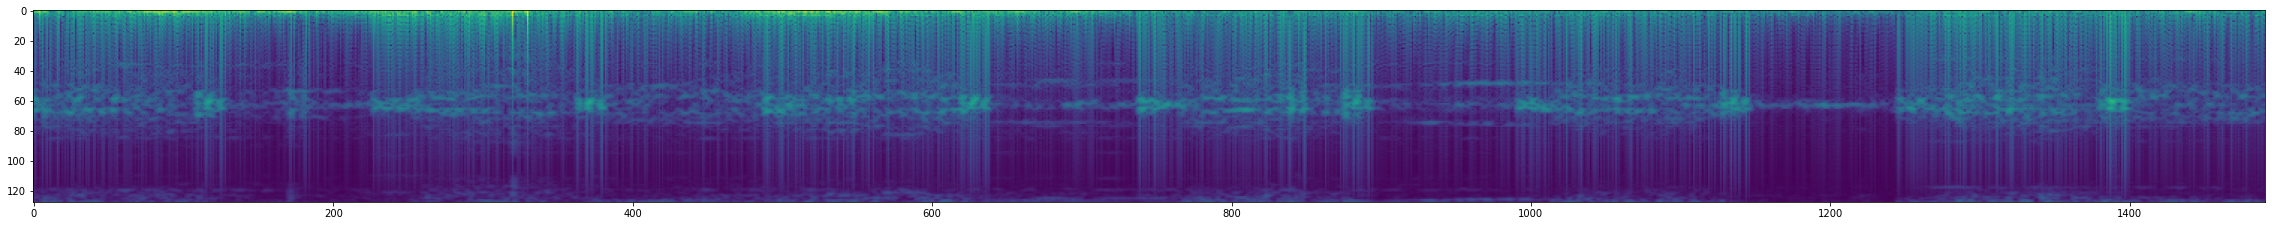

In [16]:
filepath, label = positives.shuffle(buffer_size=len(positives)).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(40, 30))
plt.imshow(tf.transpose(spectrogram[:, :, 0], (1, 0)))
plt.show()

# Create Tensorflow Data Pipeline

In [17]:
train_dataset = train_dataset.map(preprocess)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset = train_dataset.batch(batch_size=32)
train_dataset = train_dataset.prefetch(18)

test_dataset = test_dataset.map(preprocess)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(buffer_size=len(test_dataset))
test_dataset = test_dataset.batch(batch_size=32)
test_dataset = test_dataset.prefetch(18)

(None, 128)
(None, 128)


# test one batch

In [18]:
samples, labels = test_dataset.as_numpy_iterator().next()
samples.shape
print(samples.shape)

samples, labels = train_dataset.as_numpy_iterator().next()
samples.shape
print(samples.shape)

(32, 1491, 128, 1)
(32, 1491, 128, 1)


# Build our deep learning model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten


tf.config.experimental.set_memory_growth

<function tensorflow.python.framework.config.set_memory_growth(device, enable)>

In [20]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 128,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['Accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 126, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 124, 16)     2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 1485, 122, 16)     2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 1483, 120, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 2847360)           0         
                                                                 
 dense (Dense)               (None, 256)               728924416 
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [22]:
hist = model.fit(train_dataset, epochs=15, validation_data=test_dataset)

Epoch 1/15


2022-07-13 09:59:38.941000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-13 09:59:39.563295: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 67/105 [==================>...........] - ETA: 5s - loss: 5.6572 - Accuracy: 0.5378

KeyboardInterrupt: 

### Model train history

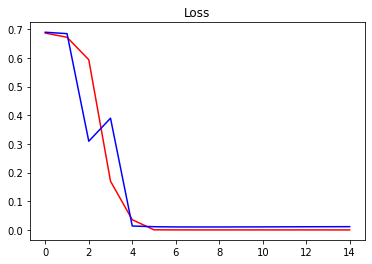

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], label='train', color='red')
plt.plot(hist.history['val_loss'], label='test', color='blue')
plt.show()

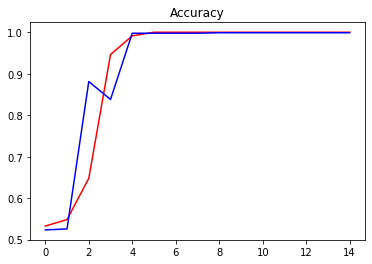

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['Accuracy'], label='train', color='red')
plt.plot(hist.history['val_Accuracy'], label='test', color='blue')
plt.show()

# Test the accuracy of model

In [ ]:
import numpy as np
from tqdm import trange, tqdm
import time
success = 0
failure = 0


pro_bar = tqdm()
pro_bar.reset()
pro_bar = tqdm(total=len(os.listdir(pos_dir)) + len(os.listdir(neg_dir)))

pro_bar.set_description('Testing Netowrk')

# load in positive files
for file in os.listdir(pos_dir):
    spectro, label = preprocess(pos_dir + file, 1)
    prediction = model.predict([np.reshape(spectro, (1, 1491, 257, 1))], verbose=0)
    if prediction[0][0] > 0.5:
        success += 1
    else:
        failure += 1
        #print("Failiure")

    pro_bar.update(1)

# load in negative files
for file in os.listdir(neg_dir):
    spectro, label = preprocess(neg_dir + file, 1)
    prediction = model.predict([np.reshape(spectro, (1, 1491, 257, 1))], verbose=0)
    if prediction[0][0] < 0.5:
        success += 1
    else:
        failure += 1
        #print("Failiure")
    pro_bar.update(1)

print("Success: " + str(success))
print("Failure: " + str(failure))

print("Success Rate: " + str(success/(success+failure)))

0it [00:00, ?it/s]


Success: 2470
Failure: 33
Success Rate: 0.9868158210147823


In [ ]:
# clear the model from memory
#del model
please stop

SyntaxError: invalid syntax (1439358283.py, line 3)

### first test
* Success: 2925
* Failure: 238
* Success Rate: 0.9247549794498894

### second test
* Success: 2664
* Failure: 499
* Success Rate: 0.8422383812835915

### third test (sus)
* Success: 3163
* Failure: 0
* Success Rate: 1.0

### fourth test (bad model)
* Success: 3158
* Failure: 5
* Success Rate: 0.9984192222573506

0.11959059
0.9992725
0.00056246645


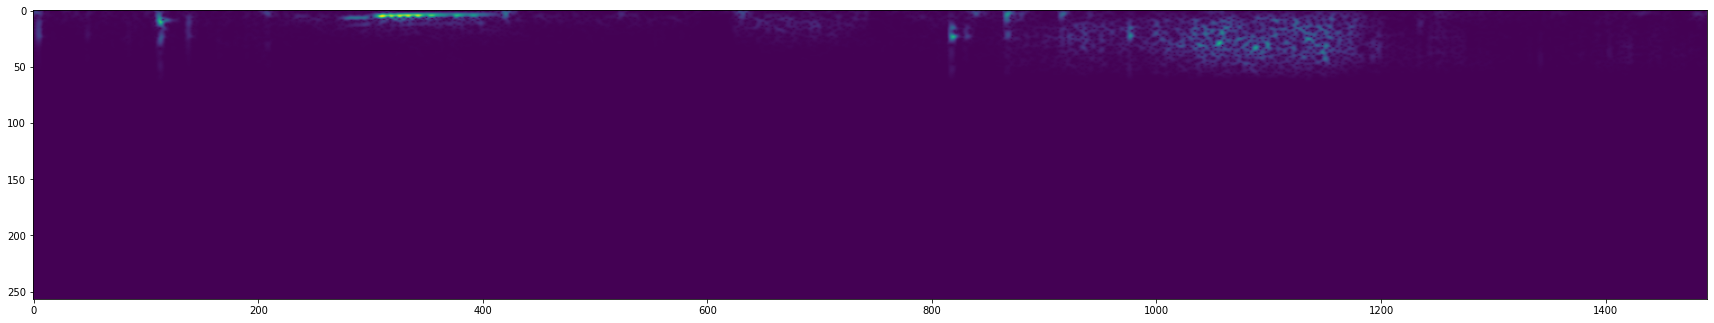

In [ ]:
import numpy as np
normal = "data/devtesting/normal.wav"
lateas = "data/devtesting/lateas.wav"
innocent = "data/devtesting/innocent.wav"

spectro, label = preprocess(normal, 1)
prediction = model.predict([np.reshape(spectro, (1, 1491, 257, 1))], verbose=0)

print(prediction[0][0])

spectro, label = preprocess(lateas, 1)
prediction = model.predict([np.reshape(spectro, (1, 1491, 257, 1))], verbose=0)

print(prediction[0][0])

spectro, label = preprocess(innocent, 1)
prediction = model.predict([np.reshape(spectro, (1, 1491, 257, 1))], verbose=0)

print(prediction[0][0])

plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()



In [ ]:
test_dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=33>

In [ ]:
import numpy as np
from tqdm import trange, tqdm
import time
success = 0
failure = 0


pro_bar = tqdm()
pro_bar.reset()
pro_bar = tqdm(total=(test_dataset.__len__().numpy()))

pro_bar.set_description('Testing Netowrk')

# load in positive files
for file in os.listdir(pos_dir_test):
    spectro, label = preprocess(pos_dir_test + file, 1)
    prediction = model.predict([np.reshape(spectro, (1, 1491, 128, 1))], verbose=0)
    if prediction[0][0] > 0.5:
        success += 1
    else:
        failure += 1
        #print("Failiure")

    pro_bar.update(1)

# load in negative files
for file in os.listdir(neg_dir_test):
    spectro, label = preprocess(neg_dir_test + file, 0)
    prediction = model.predict([np.reshape(spectro, (1, 1491, 128, 1))], verbose=0)
    if prediction[0][0] < 0.5:
        success += 1
    else:
        failure += 1
        #print("Failiure")
    pro_bar.update(1)

print("Success: " + str(success))
print("Failure: " + str(failure))

print("Success Rate: " + str(success/(success+failure)))

Testing Netowrk: : 602it [07:10,  1.40it/s]
0it [00:00, ?it/s]


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
(1491, 128)


(1491, 128)
Success: 500
Failure: 102
Success Rate: 0.8305647840531561


## fixed data bug
* Success: 511
* Failure: 144
* Success Rate: 0.7801526717557252

## data splitting run for longer maybe weird
* Success: 548
* Failure: 107
* Success Rate: 0.8366412213740458

## data splitting still weird
* Success: 511
* Failure: 91
* Success Rate: 0.8488372093023255


In [ ]:
# test the model on the test dataset
model.evaluate(test_dataset)

33/33 [==============================] - 3s 78ms/step - loss: 0.0237 - Accuracy: 0.9942


[0.023709049448370934, 0.9941860437393188]